In [1]:
library(glmmSeq)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



In [2]:
load('h5ad/df.fil3_gex_bcells_vdj_sce_B_nonswitched_mem_deg.RData')
ls()

[1] "res1"     "res2"     "res3"     "results1" "results2" "results3"

In [3]:
library(dplyr)
makeGeneList <- function(gl, beta_column='LFC'){
    y <- grepl('^RPS|^RPL|^MT-', row.names(gl))
    gl <- gl[!y, ]
    rank <- -log10(gl$pval) * sign(gl[,beta_column])
    rank[which(rank == Inf)] <- 300
    rank[which(rank == -Inf)] <- 300
    names(rank) <- row.names(gl)
    rank <- rev(sort(rank))
    gl <- rank
    return(gl)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
head(results1)
dim(results1)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IMMT,1.1916111,4.185141e-05,0.000951906,1.370455,0,0
ITFG1,1.0931763,2.740703e-04,0.004867751,1.222658,0,0
MRPL37,1.0792154,6.385398e-05,0.001375174,1.302452,0,0
PPIE,1.0328894,4.344591e-04,0.007068682,1.162836,0,0
PRDX3,1.0072519,1.486532e-03,0.015703694,1.162056,0,0
RNASE6,0.9901341,7.073146e-04,0.009853777,1.215977,0,0


[1] 4171    6

In [5]:
head(results2)
dim(results2)

,fixed-effects estimates_linear,fixed-effects estimates_quadratic,pval,qval,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNFN,9.022088,9.504860,1.929288e-04,3.160438e-04,0,0
MORC3,8.873583,9.026266,8.906589e-09,5.938798e-08,0,0
SUDS3,8.962088,8.777572,3.709639e-07,1.473485e-06,0,0
FAM111A,10.523358,8.486385,9.368348e-04,1.277942e-03,0,0
RAPGEF6,10.918810,8.446536,2.955615e-03,3.641775e-03,0,0
SH2D3C,5.105788,6.730090,2.830520e-05,5.937501e-05,0,0


[1] 3445    6

In [6]:
head(results3)
dim(results3)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EBI3,0.9166027,0.01267603,0.3479254,0.9708506,0,0
CXCR3,0.7810184,0.01639869,0.3908817,0.9145466,0,0
HMOX1,0.6964144,0.11065957,0.6295998,0.7161314,0,0
STMN1,0.6854000,0.02944999,0.4681793,0.7353617,0,0
PRDX3,0.6643700,0.02592793,0.4463852,0.7353074,0,0
FCRL5,0.6321355,0.11962432,0.6320372,0.7236890,0,0


[1] 4395    6

In [7]:
head(results4)
dim(results4)

ERROR: Error in head(results4): object 'results4' not found


In [8]:
head(results5)
dim(results5)

ERROR: Error in head(results5): object 'results5' not found


In [9]:
library(fgsea)
library(msigdbr)

In [10]:
h <- data.frame(msigdbr::msigdbr(category = "H", species = 'Homo sapiens'))
h <- split(h, h$gs_name)
h <- lapply(h, function(x) x %>% dplyr::select(gene_symbol) %>% unlist %>% as.character)

In [36]:
plotGSEA_Hallmark <- function(gsea, fdr_cutoff = 0.05, cols = NULL, xlim = NULL, newlabels = NULL, keep_significant_only = TRUE, jitter = FALSE) {
    require(ggplot2)
    gsea$NES[which(is.na(gsea$NES))] <- 0
    gsea$pval[which(is.na(gsea$pval))] <- 1
    gsea$padj[which(is.na(gsea$padj))] <- 1
    gsea$ranking[which(is.na(gsea$ranking))] <- 0
    gsea <- gsea[order(gsea$ranking),]
    
    if (keep_significant_only){
        gseax <- split(gsea, gsea$pathway)
        for (i in 1:length(gseax)){
            if (all(gseax[[i]]$pval >= 0.05)|all(gseax[[i]]$padj >=fdr_cutoff)){
                gseax[[i]] <- NA        
            }
        }
        gseax <- gseax[!is.na(gseax)]
        gsea <- do.call(rbind, gseax)        
    }
    if (!is.null(gsea)){
        gsea <- gsea[order(gsea$ranking), ]
        gsea$pathway <- gsub("HALLMARK_|", "", gsea$pathway)

        if (!is.null(xlim)){
            x_lim_min = -xlim
            x_lim_max = xlim
        } else {
            x_lim_min <- abs(ceiling(min(-log10(gsea$padj))))
            x_lim_max <- abs(ceiling(max(-log10(gsea$padj))))
        }
        
        if(x_lim_min > x_lim_max){
            xval1 <- x_lim_min * -1
            xval2 <- x_lim_min
        } else {
            xval1 <- x_lim_max * -1
            xval2 <- x_lim_max
        }

        if(!is.null(cols)){
            gg_color_hue <- function(n) {
                hues = seq(15, 375, length = n + 1)
                hcl(h = hues, l = 65, c = 100)[1:n]
            }
            cols. = gg_color_hue(dplyr::n_distinct(gsea$group, na.rm = TRUE))
        } else {
            cols. = cols
        }    
    
        g <- ggplot(gsea, aes(x = -log10(padj)*sign(NES), y = reorder(pathway, ranking), col = -log10(padj)*sign(NES), size = abs(NES)))
        if (jitter){
            g <- g + geom_point(position = 'jitter')
        }else{
            g <- g + geom_point()
        }
        g <- g + theme_bw() +
            labs(x = expression(paste("Signed", " -log" ["10"], "adjusted pval")), y = "Hallmarks") +
            scale_color_gradient2(low = '#2166ac', mid = '#f7f7f7', high = '#b2182b', na.value = NA, limits = c(-2,2), oob = scales::squish) +
            geom_vline(xintercept = 0) +
            geom_vline(xintercept = -log10(fdr_cutoff), colour = '#ff7f0e') +
            geom_vline(xintercept = -log10(fdr_cutoff)*-1, colour = '#ff7f0e') +
            scale_x_continuous(limits = c(xval1, xval2), oob = scales::squish) +
            scale_size_area(oob = scales::squish, max_size = 3, limits = c(0,2)) +
            theme(panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(), 
                panel.background = element_blank(), 
                axis.line = element_blank(), 
                axis.ticks = element_blank(),
                axis.text = element_text(color = 'black'),
                axis.title = element_text(color = 'black'),
                legend.direction = "vertical", legend.box = "horizontal"
                )
        
        return(g)
    }
}

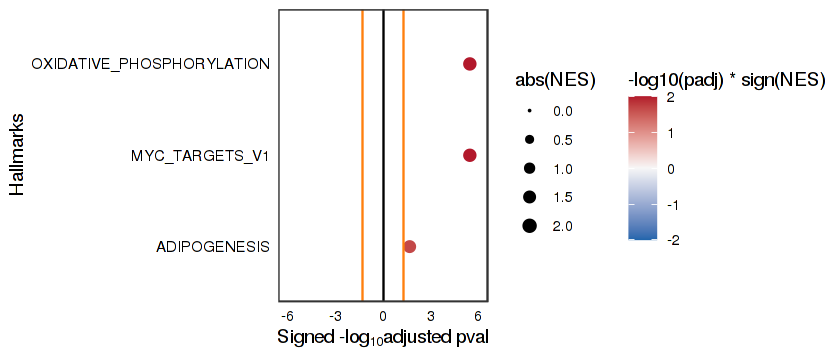

In [37]:
options(repr.plot.height = 3)
gl1 <- makeGeneList(results1)
res1gsea <- fgsea(pathways = h, stats = gl1, minSize = 0, maxSize =1000)
res1gsea$ranking <- -log10(res1gsea$pval) * sign(res1gsea$NES)
plotGSEA_Hallmark(res1gsea)

In [38]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_linear')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

In [39]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_quadratic')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


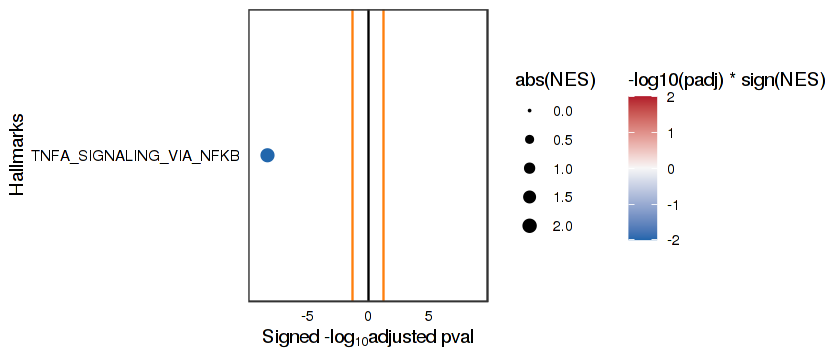

In [40]:
options(repr.plot.height = 3)
gl3 <- makeGeneList(results3)
res3gsea <- fgsea(pathways = h, stats = gl3, minSize = 0, maxSize =1000)
res3gsea$ranking <- -log10(res3gsea$pval) * sign(res3gsea$NES)
plotGSEA_Hallmark(res3gsea)

In [41]:
# options(repr.plot.height = 4)
# gl4 <- makeGeneList(results4)
# res4gsea <- fgsea(pathways = h, stats = gl4, minSize = 0, maxSize =1000)
# res4gsea$ranking <- -log10(res4gsea$pval) * sign(res4gsea$NES)
# plotGSEA_Hallmark(res4gsea)

In [42]:
# options(repr.plot.height = 3)
# gl5 <- makeGeneList(results5)
# res5gsea <- fgsea(pathways = h, stats = gl5, minSize = 0, maxSize =1000)
# res5gsea$ranking <- -log10(res5gsea$pval) * sign(res5gsea$NES)
# plotGSEA_Hallmark(res5gsea)